This notebook focuses on how to visulaize the uncertanity in our data. Uncertanity is a formalized method of representing of how unsure any estimate of some value is. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
pollution_data = pd.read_csv("assets/pollution-wide.csv")

pollution_data.head()

,city,year,month,day,CO,NO2,O3,SO2
0,Cincinnati,2012,1,1,0.245,20.0,0.030,4.20
1,Cincinnati,2012,1,2,0.185,9.0,0.025,6.35
2,Cincinnati,2012,1,3,0.335,31.0,0.025,4.25
3,Cincinnati,2012,1,4,0.305,25.0,0.016,17.15
4,Cincinnati,2012,1,5,0.345,21.0,0.016,11.05


You may want to show the uncertanity in these cases:

* Estimates from sample
  * Average of a subset
  * Linear model coefficients


You probably won't need to worry about uncertanity in these cases:

* Facts
  * Counts
  * Summarization of the entire population

### Confidence Intervals

If we want to visualize the confidence interval of an estimate, we will use `plt.hlines`

```python
plt.hlines(
    xmin = x_min,
    xmax = x_max,
    linewidth = 5,
    data = df,
    color = "blue",
    alpha = 0.7
)
```

In [8]:
ci_df = pd.DataFrame(
    {
        'year': [2013, 2014, 2015],
        'mean': [0.84, -1.33, -0.64],
        'std_err': [0.87, 0.76, 0.62],
    }
)

ci_df

,year,mean,std_err
0,2013,0.84,0.87
1,2014,-1.33,0.76
2,2015,-0.64,0.62


In [10]:
ci_df["lower"] = ci_df["mean"] - ci_df["std_err"] * 1.96
ci_df["upper"] = ci_df["mean"] + ci_df["std_err"] * 1.96

([<matplotlib.axis.YTick at 0x26a45d465e0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

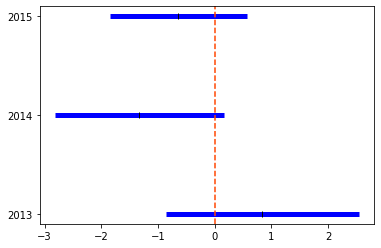

In [19]:
plt.hlines(
    data = ci_df,
    y = "year",
    xmin = "lower",
    xmax = "upper",
    linewidth = 5,
    color = "blue"
)

plt.plot(
   "mean",
   "year",
   "k|",
   data = ci_df
)

plt.axvline(
    x = 0,
    color = "orangered",
    linestyle = "--"
)

plt.yticks(range(2013, 2016))

### Continuous estimate functions

For confidence intervals that are calculated over a continous variable (usually time), we usually prefer to visualize the confidence intervals in a continous matter instead of showing it for the points we calculated for.

We can use for this target the `matplotlib` function, `fill_between`


```python
plt.fill_between(
    x = "day",
    y1 = "lower",
    y2 = "upper",
    data = ci_df
)
```

In [108]:
pollution_2014 = pollution_data.copy()
pollution_2014_city = pd.pivot_table(data = pollution_2014, index = ["city", "day"], values = "NO2", aggfunc = [np.mean, np.std])
pollution_2014_city["lower"] = pollution_2014_city["mean"] - 1.96 * pollution_2014_city["std"]
pollution_2014_city["upper"] = pollution_2014_city["mean"] + 1.96 * pollution_2014_city["std"]

pollution_2014_city_df = pd.DataFrame(pollution_2014_city.to_records())
pollution_2014_city_df.columns = ["city", "day", "NO2_mean", "NO2_std", "NO2_lower", "NO2_upper"]
pollution_2014_city_df

,city,day,NO2_mean,NO2_std,NO2_lower,NO2_upper
0,Cincinnati,1,20.00,4.000000,12.160000,27.840000
1,Cincinnati,2,16.00,9.899495,-3.403010,35.403010
2,Cincinnati,3,25.50,7.778175,10.254778,40.745222
3,Cincinnati,4,17.50,10.606602,-3.288939,38.288939
4,Cincinnati,5,19.00,2.828427,13.456283,24.543717
...,...,...,...,...,...,...
2731,Vandenberg Air Force Base,362,1.75,1.500000,-1.190000,4.690000
2732,Vandenberg Air Force Base,363,3.00,2.828427,-2.543717,8.543717
2733,Vandenberg Air Force Base,364,2.00,1.414214,-0.771859,4.771859
2734,Vandenberg Air Force Base,365,1.50,0.577350,0.368393,2.631607


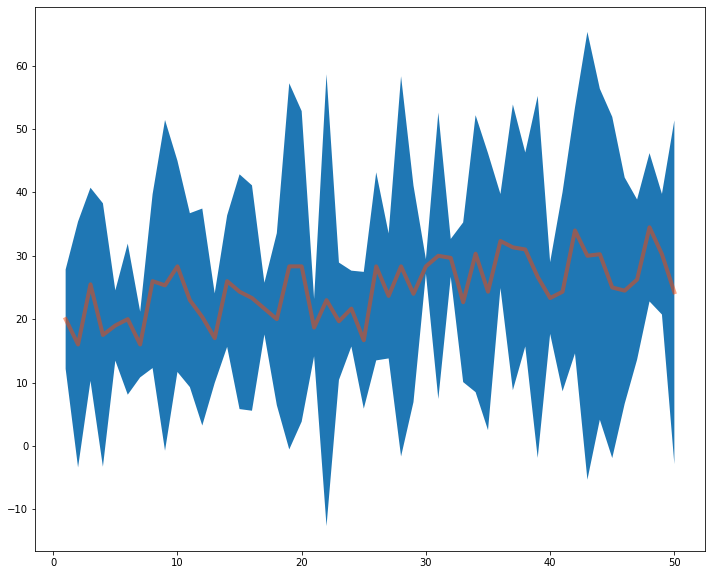

In [109]:
plt.figure(figsize=(12, 10))
plt.fill_between(
    # plot only for Cincinnati for the first 25 days
    data = pollution_2014_city_df[pollution_2014_city_df.city == "Cincinnati"].iloc[:50, :],
    x = "day",
    y1 = "NO2_lower",
    y2 = "NO2_upper"
)

plt.plot(
    "day",
    "NO2_mean",
    data = pollution_2014_city_df[pollution_2014_city_df.city == "Cincinnati"].iloc[:50, :],
    color = "orangered",
    linewidth = 4,
    alpha = 0.5
)

If we tried to plot the intervals of each city,

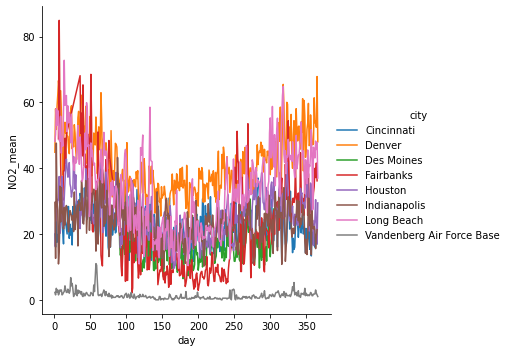

In [110]:
sns.relplot(
    data = pollution_2014_city_df,
    x = "day",
    y = "NO2_mean",
    hue = "city",
    style = "city",
    kind = "line",
    dashes = False
)

Not that pleasing looking, it's better if we have multiple classes (here multiple cities), we should plot each city in its own plot. We can use here `sns.FacetGrid` to create a subplot for each city.

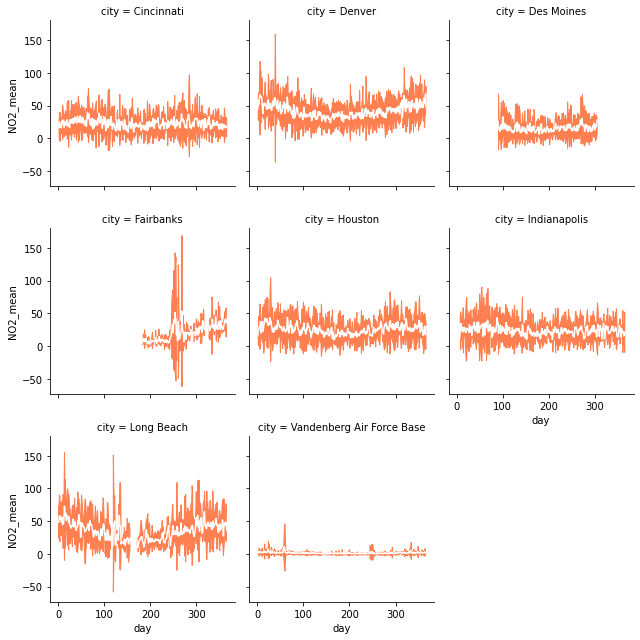

In [111]:
g = sns.FacetGrid(
    data = pollution_2014_city_df,
    col = "city",
    col_wrap = 3
)

g.map(
    plt.fill_between,
    "day",
    "NO2_lower",
    "NO2_upper",
    color = "coral"
)

g.map(
    plt.plot,
    "day",
    "NO2_mean",
    color = "white"
)

If we only have only 2 classes, we can easily plot them on the same axes and make some modifications to the color like this,

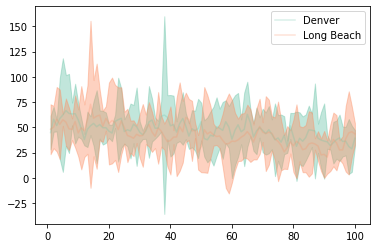

In [106]:
for city, color in [('Denver', '#66c2a5'), ('Long Beach', '#fc8d62')]:
    city_data = pollution_2014_city_df[pollution_2014_city_df.city == city].iloc[:100, :]
    plt.fill_between(x = "day", y1 = "NO2_lower", y2 = "NO2_upper", data = city_data, color = color, alpha = 0.4)
    plt.plot("day", "NO2_mean", data = city_data, color = color, alpha = 0.25, label = city)

plt.legend()

### Plotting multiple confidence intervals

We can show confidence intverals for the same estimate but with different confidence levels (90%, 95%, 99%)

In [112]:
pollution_2014 = pollution_data.copy()
pollution_2014_city = pd.pivot_table(data = pollution_2014, index = ["city", "day"], values = "NO2", aggfunc = [np.mean, np.std])
pollution_2014_city["lower_90%"] = pollution_2014_city["mean"] - 1.57 * pollution_2014_city["std"]
pollution_2014_city["upper_90%"] = pollution_2014_city["mean"] + 1.57 * pollution_2014_city["std"]

pollution_2014_city["lower_95%"] = pollution_2014_city["mean"] - 1.96 * pollution_2014_city["std"]
pollution_2014_city["upper_95%"] = pollution_2014_city["mean"] + 1.96 * pollution_2014_city["std"]

pollution_2014_city["lower_99%"] = pollution_2014_city["mean"] - 2.58 * pollution_2014_city["std"]
pollution_2014_city["upper_99%"] = pollution_2014_city["mean"] + 2.58 * pollution_2014_city["std"]

pollution_2014_city_df = pd.DataFrame(pollution_2014_city.to_records())
pollution_2014_city_df.columns = ["city", "day", "NO2_mean", "NO2_std", "NO2_lower_90%", "NO2_upper_90%", "NO2_lower_95%", "NO2_upper_95%", "NO2_lower_99%", "NO2_upper_99%"]
pollution_2014_city_df

,city,day,NO2_mean,NO2_std,NO2_lower_90%,NO2_upper_90%,NO2_lower_95%,NO2_upper_95%,NO2_lower_99%,NO2_upper_99%
0,Cincinnati,1,20.00,4.000000,13.720000,26.280000,12.160000,27.840000,9.680000,30.320000
1,Cincinnati,2,16.00,9.899495,0.457793,31.542207,-3.403010,35.403010,-9.540697,41.540697
2,Cincinnati,3,25.50,7.778175,13.288266,37.711734,10.254778,40.745222,5.432310,45.567690
3,Cincinnati,4,17.50,10.606602,0.847635,34.152365,-3.288939,38.288939,-9.865032,44.865032
4,Cincinnati,5,19.00,2.828427,14.559369,23.440631,13.456283,24.543717,11.702658,26.297342
...,...,...,...,...,...,...,...,...,...,...
2731,Vandenberg Air Force Base,362,1.75,1.500000,-0.605000,4.105000,-1.190000,4.690000,-2.120000,5.620000
2732,Vandenberg Air Force Base,363,3.00,2.828427,-1.440631,7.440631,-2.543717,8.543717,-4.297342,10.297342
2733,Vandenberg Air Force Base,364,2.00,1.414214,-0.220315,4.220315,-0.771859,4.771859,-1.648671,5.648671
2734,Vandenberg Air Force Base,365,1.50,0.577350,0.593560,2.406440,0.368393,2.631607,0.010436,2.989564


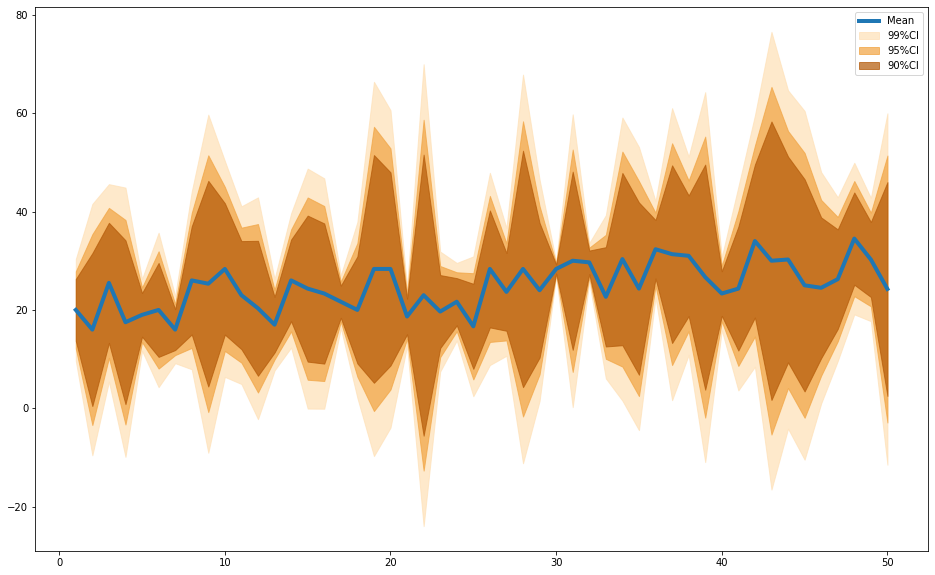

In [120]:

cl = ['99%', '95%', '90%']
cl_factors = [2.58, 1.96, 1.57]
colors = ["#fee0b6", "#f1a340", "#b35806"] # use nominal colors (the narrower the interval is, the darkest the color is)

cl_data = pollution_2014_city_df[pollution_2014_city_df.city == "Cincinnati"].iloc[:50, :]


plt.figure(figsize=(16, 10))
for cl_label, cl_factor, color in zip(cl, cl_factors, colors):
    plt.fill_between(
        data = cl_data,
        x = "day",
        y1 = "NO2_lower_{}".format(cl_label),
        y2 = "NO2_upper_{}".format(cl_label),
        color = color,
        alpha = 0.7,
        label = cl_label + "CI"
    )

plt.plot("day", "NO2_mean", data = cl_data, linewidth = 4, label = "Mean")
plt.legend()

### Visualizing the bootstrap

Bootstrap is another measure of uncertanity that calculates the support of the estimate probability by taking many samples of the observed values.

<AxesSubplot:ylabel='Count'>

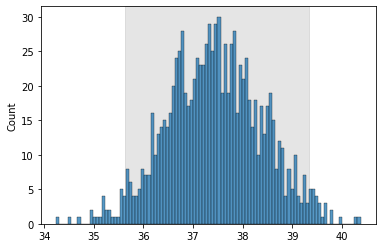

In [126]:
denver_may = pollution_data.query("city == 'Denver' & month == 8")

def bootstrap(data, n_boots):
    return [np.mean(np.random.choice(data, len(data))) for _ in range(n_boots)]

boots_mean = bootstrap(denver_may.NO2, 1000)

lower, upper = np.percentile(boots_mean, [2.5, 97.5])

plt.axvspan(lower, upper, color = "grey", alpha = 0.2)
sns.histplot(boots_mean, bins=100)

We can also fit a regression line for each sample and plot all the lines fitted to our bootstrap samples.

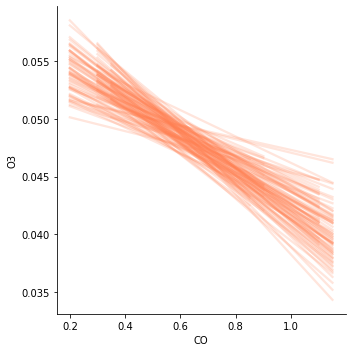

In [132]:
denver_may_boot = pd.concat([
    denver_may.sample(n = len(denver_may), replace = True).assign(sample = i)
for i in range(100)])

sns.lmplot(
    x = "CO",
    y = "O3",
    data = denver_may_boot,
    scatter = False,
    hue = "sample",
    legend = False,
    ci = None,
    line_kws = {"color": "coral", "alpha": 0.2}
)

<AxesSubplot:xlabel='NO2_avg', ylabel='city'>

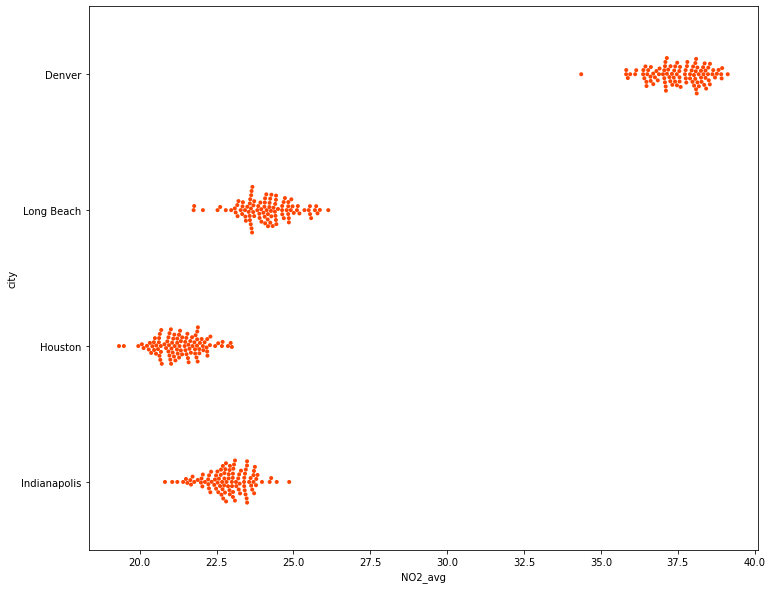

In [141]:
aug_poll = pollution_data.query("month == 8")

city_boots = pd.DataFrame()

for city in ["Denver", "Long Beach", "Houston", "Indianapolis"]:
    city_NO2 = aug_poll[aug_poll.city == city].NO2
    cur_boot = pd.DataFrame({
        "NO2_avg": bootstrap(city_NO2, 100),
        "city": city
    })
    city_boots = pd.concat([city_boots, cur_boot])

plt.figure(figsize = (12, 10))
sns.swarmplot(y = "city", x = "NO2_avg", data = city_boots, size = 4, color = "orangered")